# Sampling damage distributions

By @cherryjesus

2023-11-26

## Introduction

"I didn't crit", a phrase often muttered when damage dealt is lower than expected. The mechanics of how different hit types lead to damage variability is well understood, but the arising damage distribution remains far from a routine calculation and is often unknown. Currently, most tools which account for variability do not give precise information about the likelihood for dealing a specific amount of damage. Most typically report statistics like a mean and standard deviation. While these statistics are useful and can give a rough idea of how much damage can vary, information about the damage distribution is still limited - especially when DPS distributions are non-normal. There are likely many efforts for accurately computing damage variability and/or damage distributions. However, these tend to either not be publicly available, might not be generalizable to all jobs, easily accommodate rotational changes, and often rely on approximate/more computationally expensive techniques like random sampling.

The degree of how "good" a run is often retrospectively gauged by the hit type rates of heavier-hitting actions. A higher percentage of critical, direct, and critical-direct hits corresponds to more damage dealt. However, translating hit type rates to damage dealt is often a murky process. Many different combinations of rates across different actions can lead to the same damage dealt. It is also difficult to estimate how likely higher damage runs are and by how much damage. Such eyeballing efforts are even more challenging for proc-based jobs, where the number of actions can be random.

The third installment in modeling damage variability continues on the premise that a damage rotation gives rise to a distribution of damage dealt due to hit type variability and random damage rolls. This analysis will focus on applying the theory developed in prior work, [*Variability in damage calculations*](/01_variability_in_damage_calculations/Variability%20in%20damage%20calculations.pdf) and [*Damage distributions for deterministic and stochastic rotations*](/02_damage_distributions_deterministic_stochastic/Damage%20distributions%20for%20deterministic%20and%20stochastic%20rotations.pdf), by analyzing and predicting real rotations performed in-game. We also introduce the idea that each time the rotation is executed in an encounter can be thought of as drawing a sample from the damage distribution. Damage distributions are exactly calculated from methods developed in previous work, which has been created as a Python package, `ffxiv_stats`. This notebook aims to accomplish the following:

1. Illustrate *ab initio* damage distribution calculations. How to calculate an exact damage distribution starting from a job build with stats and a rotation.
2. Computed DPS distributions are compared to samples results are compared to real data recorded in-game to help validate computations. 
3. Discuss performing a rotation through the lens of sampling a damage rotation and its applications towards comparing job builds, party compositions, and rotations in a speed killing and parsing setting.




## Example 1: A simple WHM rotation

For this example, we compute the DPS distribution (the damage distribution divided by encounter length) that arises for a simple WHM rotation. The same DPS distribution is also sampled in-game 49 times to estimate the true DPS distribution. The term "rotation" is used in the strictest sense where the explicit number of action usages and buffs present defines a unique rotation that depends on both party composition and kill time. "Sampling the DPS distribution" for this example is simply repeating the same rotation on a striking dummy 49 times. The rotation is:

| Action          | n  |
|-----------------|----|
| Glare III       | 31 |
| Assize          | 3  |
| Dia             | 3  |
| Dia (tick)      | 30 |
| Afflatus Misery | 1  |

With a total time elapsed of `t=96s`. 

The WHM build used is [far from BiS](https://etro.gg/gearset/27eb1f5b-1f98-4d3b-a038-9dc339379d9a). The table below summarizes important stats and multipliers

| Stat                   | Value  |
|------------------------|--------|
| Weapon DMG             | 128    |
| MND                    | 3341   |
| DH                     | 724    |
| CRT                    | 2346   |
| DET                    | 1939   |
| SPS                    | 820    |
| CH rate                | 25.4%  |
| CH Multiplier          | 160.4% |
| DH rate                | 9.3%   |
| DET Multiplier         | 111.4% |
| SPS Multiplier         | 102.8% |

With this build, 100 potency hit will deal `3920` damage before any variability is introduced. Using the `ffxiv_stats` module, the DPS distribution can be readily computed. 

In [1]:
import time
import json

import numpy as np
import pandas as pd
# Precision beyond tenths place not needed for any float values here
pd.options.display.float_format = '{:.1f}'.format 
import matplotlib.pyplot as plt
import seaborn as sns

from rla import get_pull_dps_actions_from_fflogs, create_action_df, create_rotation_df 

# Install with `pip install "ffxiv_stats==0.2.1"`, the specific version might be required since
# the API is not locked in and will likely change
from ffxiv_stats.jobs import Healer

In [2]:
reference_rotation = pd.read_json('data/whm_reference_rotation.json')
t_ex = 96

mind = 3341
intelligence = 410
vit = 3280
strength = 213
dexterity = 411
determination = 1939
sks = 400
sps = 820
ten = 400
dh = 724
ch = 2346
wd = 128
delay = 3.44

# Job object to convert potencies to damage dealt
whm = Healer(mind, intelligence, vit, strength, dexterity, determination,
             sks, sps, ten, ch, dh, wd, delay)

# Attaching a rotation find corresponding d2 values and performs all variability calculations
# Convolve computes all DPS distributions through convolutions. If an action has enough hits,
# a skew-normal distribution can be parameterized by the exactly-computed moments.
# This is typically much faster and closely resembles the exact distribution, but the error analysis
# needs to be further investigated. 
whm.attach_rotation(reference_rotation, t_ex, convolve_all=True)
print("Damage of 100 potency ability before variability:", whm.direct_d2(100))

reference_rotation

Damage of 100 potency ability before variability: 3920.0


,action_name,base_action,n,p,buffs,l_c,main_stat_add,potency,damage_type,d2,is_dot
4,Afflatus Misery,Afflatus Misery,1,"[0.676622, 0.230378, 0.069378, 0.023622]",[1],1604,0,1240,direct,48646.0,0
3,Assize,Assize,3,"[0.676622, 0.230378, 0.069378, 0.023622]",[1],1604,0,400,direct,15691.0,0
2,Dia,Dia,3,"[0.676622, 0.230378, 0.069378, 0.023622]",[1],1604,0,65,direct,2548.0,0
1,Dia (tick),Dia (tick),30,"[0.676622, 0.230378, 0.069378, 0.023622]",[1],1604,0,65,magic-dot,2601.0,1
0,Glare III,Glare III,31,"[0.676622, 0.230378, 0.069378, 0.023622]",[1],1604,0,310,direct,12161.0,0


The rotation is defined by each unique action (`action_name`), the number of hits (`n`), the probability of each hit type (`p`, normal, critical, direct, critical-direct hit), the critical hit multiplier (`l_c`), the damage dealt before hit-type and damage rolls are determined (`d2`), and whether the action is a damage over time effect (`is_dot`). The `action_name` field is a unique identifier for each action and buff(s) present and `base_action` is the action name ignoring any sort of buffs. If Chain Stratagem was present for some Glare III casts, there would be an additional record with and `action_name` something like `Glare III CS` and `base_action` would remain `Glare III`. The latter field is used to easily group all actions together for computing DPS distributions for each base action. 

The remaining columns were used in converting potency to actual damage dealt: the potency of each action (`potency`), the presence of medication and how much it increases the main stat by (`main_stat_add`), and what type of damage is dealt (`damage_type`).

The DPS distribution has a mean of 6864 DPS and standard deviation of 264 DPS. There is a visible positive skew with a skewness of 0.31 due to the small number of total hits in the rotation and high-potency action Afflatus Misery.

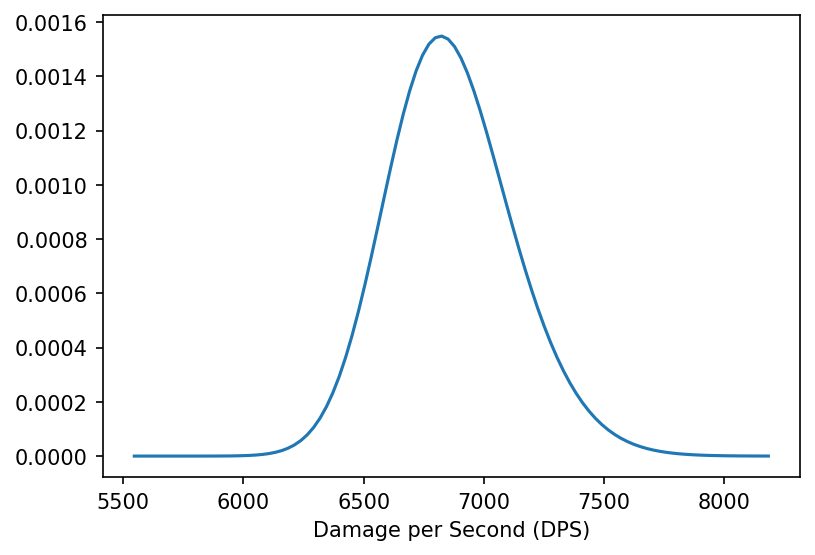

Rotation mean: 6864.3 DPS
Rotation std:  263.7 DPS
Rotation skew: 0.31
Coefficient of variation: 0.038


In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
whm.plot_rotation_distribution(ax=ax)
plt.show()
print(f"Rotation mean: {whm.rotation_mean:.1f} DPS")
print(f"Rotation std:  {whm.rotation_std:.1f} DPS")
print(f"Rotation skew: {whm.rotation_skewness:.2f}")
print(f"Coefficient of variation: {(whm.rotation_std / whm.rotation_mean):.3f}")

Next, the above DPS distribution is sampled 49 times by performing the rotation on a striking dummy in-game. This serves to both help validate the analysis and illustrate the concept of sampling a DPS rotation. Since the theoretical DPS distribution is bell-shaped with a modest coefficient of variation, 49 samples should yield a sample mean and standard deviation that is close to the true mean/standard deviation.

One important note about this simple rotation: the rotation is not an optimal WHM rotation, but there is also no need for it to be. The rotation was programmed as a macro and rotational consistency among samples was prioritized since any changes to the rotation will sample a different DPS distribution e.g., overwriting Dia before all 10 ticks occur. Whether the rotation is optimal or not has no effect towards the steps in analyzing how variability from hit types and damage rolls gives rise to the DPS distribution.

The rotation was performed 49 times, recorded in ACT, and then uploaded to FFLogs for processing. The data pertaining to damage dealt for each sample (pull) can be readily obtained using the FFlogs API and have been stored locally as JSON files in [`data`](/03_sampling_damage_distributions/data/). The DPS for each pull is computed and are used to create a histogram to compare against the theoretical DPS distribution. The black rug at the bottom shows the specific DPS values for each sample.

In [4]:
# Load in all actions for each sample (pull) as nested dictionaries
# See the appendix for how the API calls are performed
with open('data/all_action_dfs.json') as json_data:
    all_actions = json.load(json_data)

# Total dmg dealt is just sum of "amount" field when converted to a dataframe
samples_total_dmg = []
for (k, v) in all_actions.items():
    samples_total_dmg.append(pd.DataFrame(v)['amount'].sum())

# Convert to array and also compute DPS
samples_total_dmg = np.array(samples_total_dmg)
samples_dps = samples_total_dmg / t_ex

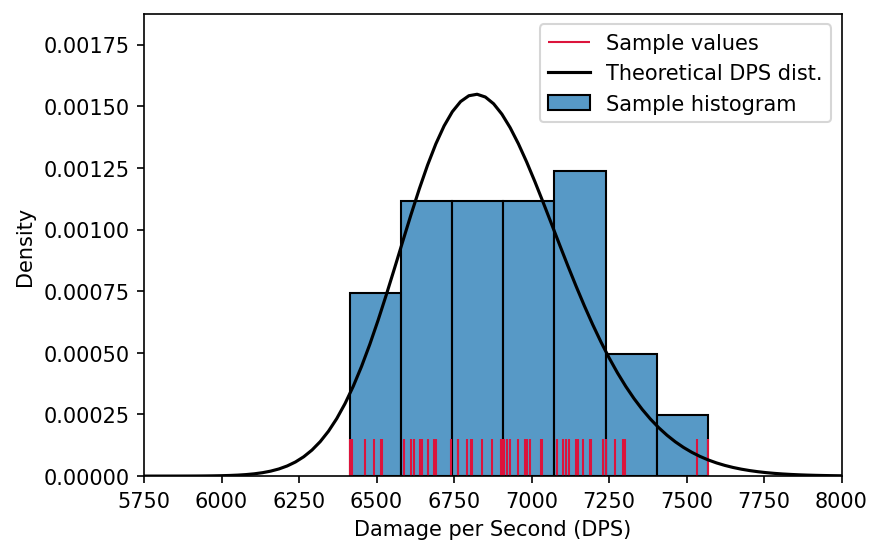

Sample mean: 6910.1 DPS
Standard error 40.1 DPS
Exact mean: 6864.3 DPS

Sample StD: 280.6 DPS
Exact StD: 263.7 DPS


In [52]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)

sns.histplot(samples_dps, ax=ax, stat="density", label='Sample histogram')
sns.rugplot(samples_total_dmg / t_ex, ax=ax, height=0.08, color='crimson', label='Sample values')
whm.plot_rotation_distribution(ax=ax, c='k', label='Theoretical DPS dist.')
ax.legend()
ax.set_xlim([5750, 8000])
plt.show()

print(f"Sample mean: {samples_dps.mean():.1f} DPS")
print(f"Standard error {samples_dps.std() / np.sqrt(samples_dps.size):.1f} DPS")
print(f"Exact mean: {whm.rotation_mean:.1f} DPS")
print()
print(f"Sample StD: {samples_dps.std():.1f} DPS")
print(f"Exact StD: {whm.rotation_std:.1f} DPS")

The sample mean and exact mean are within ~45 DPS of each other, about 1 standard error apart and within sampling error. A 2-sample [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) also suggests the in-game samples could be drawn from the theoretical DPS distribution (p = 0.36, see [the appendix](#ks-test-between-in-game-samples-and-predicted-damage-distribution) for the calculation). 

There are two uncommonly high values at a little over 7500 DPS, which we further analyze the higher of the two. First, we can compute the percentile for the highest-DPS run.

In [6]:
def get_dmg_percentile(dps, dmg_distribution, dmg_distribution_support):
    """
    Compute the CDF from a PDF and support, then find the corresponding percentile a value has

    inputs:
    dps - float, DPS value to find a percentile
    dmg_distribution - NumPy array of the DPS distribution
    dmg_distribution_support - NumPy array of the support ("x values") corresponding to the DPS distribution

    returns
    percentile (as a percent)
    """
    dx = dmg_distribution_support[1] - dmg_distribution_support[0]
    F = np.cumsum(dmg_distribution) * dx
    return F[(np.abs(dmg_distribution_support - dps)).argmin()] * 100


# Get key for the highest DPS run
highest_dps_key = list(all_actions.keys())[samples_dps.argmax()]
whm_ex_high_dps_actions = pd.DataFrame(all_actions[highest_dps_key])
whm_ex_high_action_dps = (
    (whm_ex_high_dps_actions[["ability_name", "amount"]].groupby("ability_name").sum() / t_ex)
)

print(f"Percentile of DPS distribution {get_dmg_percentile(whm_ex_high_action_dps.sum()[0], whm.rotation_dps_distribution, whm.rotation_dps_support):.1f}%")

Percentile of DPS distribution 99.3%


A sample that is in the 99th+ percentile of the distribution is quite uncommon. While it was visually clear that this run had much higher DPS than the other runs, it was not clear how likely a higher DPS run could be. While higher DPS runs are possible, achieving one is unlikely in the context of a Savage encounter since the DPS distribution is sampled at most a few hundred times per raid floor.

Note that this percentile does not correspond to any percentile found on FFLogs, but for this specific rotation. The DPS distribution depends on the specific rotation, which even optimal rotations can contain slightly different skill usages and result in slightly different DPS distributions. Logs on FFLogs often contain many instances of rotations which sample much lower damage DPS distributions and will be further explained in another example below. At the time of writing, FFLogs does also not compute percentiles for raw DPS.

Next, the DPS distributions for each action along with the actual DPS dealt, represented by triangles, are plotted.

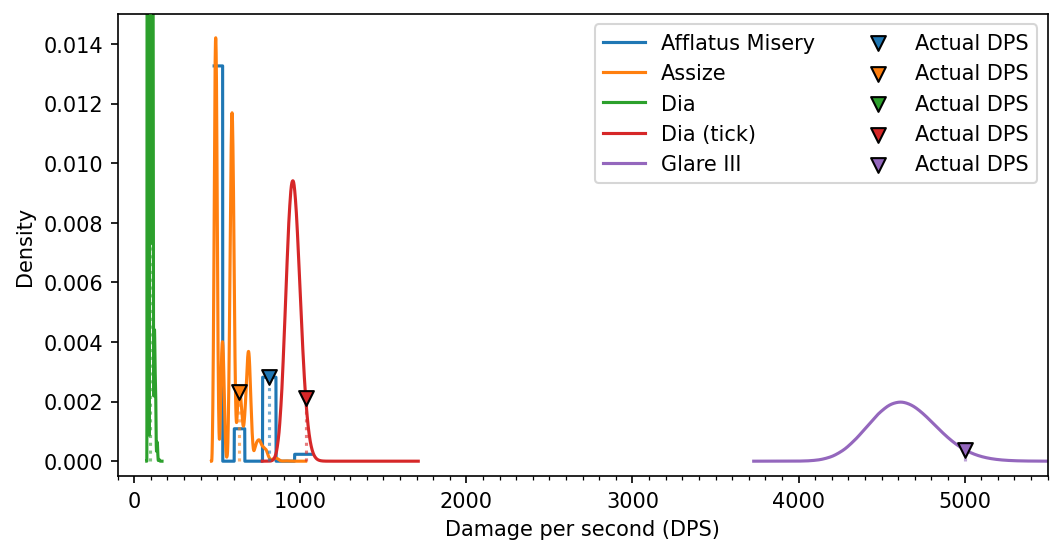

In [7]:
from matplotlib.ticker import MultipleLocator
ml_100 = MultipleLocator(100)

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150)
whm.plot_unique_action_distributions(ax=ax)

for c, x in enumerate(whm_ex_high_action_dps.reset_index().values):
    d = whm.unique_actions_distribution[x[0]]
    idx = np.abs(d['support'] - x[1]).argmin()

    # Could use stem, but there's not much customization
    ax.scatter(x[1], d['dps_distribution'][idx], marker='v', label="Actual DPS", s=50, c=f'C{c}', edgecolors='k', zorder=5)
    ax.plot([x[1], x[1]], [0, d['dps_distribution'][idx]], linestyle=(0, (1, 1.5)), c=f'C{c}', zorder=4, alpha=0.6)

ax.set_ylim(-0.0005, 0.015)
ax.set_xlim(-100, 5500)
ax.set_xlabel('Damage per second (DPS)')
ax.set_ylabel('Density')
ax.legend(ncol=2)
ax.xaxis.set_minor_locator(ml_100)
plt.show()

Unsurprisingly, most abilities reside in the high DPS tails of each distribution. For actions with few numbers of hits, Dia (application), Assize, and Afflatus Misery, the DPS distributions have not yet converged to a normal distribution, let alone a unimodal distribution. Afflatus Misery only had one hit, and the plateaus represent normal, direct, critical, and critical-direct hits, respectively. The relative height of each plateau is also proportional to the likelihood each hit type occurring. Here, the Afflatus Misery landed a critical hit, granting about 250 more DPS compared to a normal hit. The data can also be summarized tabularly, reporting the expected DPS, actual DPS dealt, and the corresponding percentile of the DPS distribution.

In [8]:
def summarize_actions(actions_df, unique_actions, t):
    """
    List the expected DPS, actual DPS dealt, and corresponding percentile.

    Inputs:
    actions_df - pandas df, dataframe of actions from `create_action_df` in `rla.py`
    unique_actions - unique_actions_distribution attribute from Job object in `ffxiv_stats`
    t - float, time elapsed. Set t=1 for damage dealt instead of dps.
    """
    action_dps = (actions_df[["ability_name", "amount"]
                             ].groupby("ability_name").sum() / t)

    action_dps = action_dps.reset_index()
    action_dps['percentile'] = action_dps.apply(
        lambda x: get_dmg_percentile(x['amount'],
                                     unique_actions[x['ability_name']
                                                                     ]['dps_distribution'],
                                     unique_actions[x['ability_name']]['support']), axis=1)

    action_dps['expected_dps'] = action_dps["ability_name"].apply(
        lambda x:
        np.trapz(unique_actions[x]['support'] * unique_actions[x]['dps_distribution'], 
                 unique_actions[x]['support'])
    )

    return action_dps[['ability_name', 'expected_dps', 'amount', 'percentile']].rename(columns={"amount": "actual_dps_dealt"})

summarize_actions(whm_ex_high_dps_actions, whm.unique_actions_distribution, t_ex).sort_values("actual_dps_dealt", ascending=False)

,ability_name,expected_dps,actual_dps_dealt,percentile
4,Glare III,4634.6,5001.0,96.0
3,Dia (tick),959.1,1031.8,95.3
0,Afflatus Misery,597.0,811.8,86.5
1,Assize,578.7,628.1,76.0
2,Dia,94.0,95.3,58.1


The above table gives a similar conclusion as the figure: the damage dealt for most actions are in the high DPS tail of the distribution. The percentile helps gauge the likelihood of dealing more DPS for each action as well as illustrate how the percentiles of individual actions compound into the percentile for the overall rotation. 

## Damage variability in speed kills

Admittedly, assessing how far in the tail of the DPS distribution a run lies is a bit niche. For a large majority of players, rotational variability is going to lead to much larger changes in DPS than hit types - especially if GCDs are lost. This analysis also considers raw DPS, and not derived DPS metrics like rDPS. However, one group who is primarily interested in sampling the tails of damage distributions and maximizing raw DPS is people who speed kill. Ultimately, their goal is to deal damage equal to a boss' HP as quickly as possible. This section discusses how distributions can be analyzed to help make decisions that increase the likelihood of faster kill times.


### Estimating kill time probability

One of the most straightforward ways a damage distribution can be analyzed is to assess how likely certain kill times are. We will stick with our simple WHM rotation instead of an 8-person party for simplicity. The steps in combining combining the DPS distributions of each job to yield an 8-person party DPS distribution is no different than the steps in combining the DPS distributions of each action to yield a rotation DPS distribution of a single job. First, assume the "boss" has 700,000 HP. Next, the DPS distribution is converted to the damage distribution and the cumulative distribution function is computed, along with the percentile corresponding to the boss' HP.

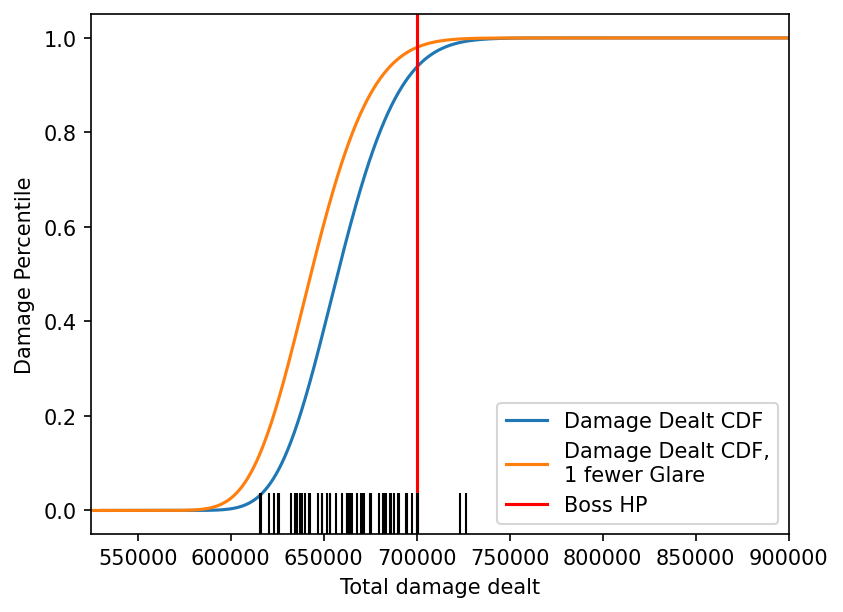

Percentile corresponding to boss HP: 93.8%
Percent of kills that are 96s or faster: 6.2%
Number of samples resulting in sub-96s kill time: 4

Rotation with one fewer Glare III cast
Percentile corresponding to boss HP: 98.0%
Percent of kills that are 93.5s or faster: 2.0%


In [9]:
boss_hp = 700000

# DPS to damage dealt by setting t = 1 second
whm.attach_rotation(reference_rotation, t=1, convolve_all=True)
dx = whm.rotation_dps_support[1] - whm.rotation_dps_support[0]
dps_cdf = np.cumsum(whm.rotation_dps_distribution) * dx

reference_rotation_truncated = reference_rotation.copy()
reference_rotation_truncated.loc[reference_rotation_truncated['action_name'] == "Glare III", "n"] = 30
whm_truncated = Healer(mind, intelligence, vit, strength, dexterity, determination,
                       sks, sps, ten, ch, dh, wd, delay)
whm_truncated.attach_rotation(reference_rotation_truncated, t=1, convolve_all=True)
truncated_dps_cdf = np.cumsum(whm_truncated.rotation_dps_distribution) * dx


fig, ax = plt.subplots(1, 1, figsize=(6,4.5), dpi=150)
ax.plot(whm.rotation_dps_support, dps_cdf, label='Damage Dealt CDF')
ax.plot(whm_truncated.rotation_dps_support, truncated_dps_cdf, label='Damage Dealt CDF,\n1 fewer Glare')
sns.rugplot(samples_total_dmg, ax=ax, height=0.08, color='k', expand_margins=False, zorder=10)
ylim = ax.get_ylim()
ax.plot([boss_hp, boss_hp], ylim, c='r', label='Boss HP')
ax.set_ylim(ylim)

ax.legend()
ax.set_xlabel("Total damage dealt")
ax.set_ylabel("Damage Percentile")
ax.set_xlim(5.25e5, 9e5)
plt.show()

print(f"Percentile corresponding to boss HP: {get_dmg_percentile(boss_hp, whm.rotation_dps_distribution, whm.rotation_dps_support):.1f}%")
print(f"Percent of kills that are {t_ex}s or faster: {(100-get_dmg_percentile(boss_hp, whm.rotation_dps_distribution, whm.rotation_dps_support)):.1f}%")
print(f"Number of samples resulting in sub-96s kill time: {samples_total_dmg[samples_total_dmg >= boss_hp].size}")
print()
print("Rotation with one fewer Glare III cast")
print(f"Percentile corresponding to boss HP: {get_dmg_percentile(boss_hp, whm_truncated.rotation_dps_distribution, whm_truncated.rotation_dps_support):.1f}%")
print(f"Percent of kills that are {t_ex-2.5}s or faster: {(100-get_dmg_percentile(boss_hp, whm_truncated.rotation_dps_distribution, whm_truncated.rotation_dps_support)):.1f}%")

For this rotation, which occurs over 96 seconds, 6.2% of pulls result in a kill time that is 96s or faster. From the in-game sample, 4 of the pulls would have resulted in a kill time under 96s (8.1%), which is quite close to the expected value 6.2%. Another way to frame this result is this kill time or faster can be expected to occur every 16 kills, on average. In the context of a Savage encounter where a team could have up to 200 kills, they could conclude that multiple kills <= 96s would be likely. The rotation can simply be truncated to give a closer estimate of the fastest kill time that could be achieved, given the kill time probability and number of runs a team plans to attempt. For this example, the new rotation could be one fewer glare cast, which would takes ~93.5s to execute. The new, truncated damage distribution (plotted in orange) and corresponding percentile of the boss' HP is computed and shows that 2% of kills would be ~93.5s or faster.

The reason the percent of kills which are *t* seconds or faster is reported instead of a potentially more intuitive metric like the distribution of kill times is because damage is modeled as depending on neither time nor action order. Whether actions are performed with the "GCD rolling" or minutes apart has no impact on damage variability. Assuming action combos remain unbroken, the same is also true for the order which actions are performed - casting Assize then Glare has the same damage variability as casting Glare then Assize. Time only enters the analysis as an external parameter corresponding to how long a rotation takes to perform due to the battle system. Computing a kill time distribution explicitly would require damage to depend on both time and action sequence, since boss HP must be tracked as actions are performed at specific time points. Computing a kill time also involves more complex conditional probabilities to ensure previous actions did not deal more damage than the boss' HP. The underlying methodology of convolving single-hit damage distributions could be modified to account for these new dependencies. This would introduce much more complexity and in most cases, not provide any new information that can be used to increase the chance of faster kill times. 

One outstanding challenge in accurately computing damage distributions is accounting for additional damage variance imparted by jobs with stochastic rotations - jobs where the number of times an action, or an entire rotation, is randomly distributed. Most stochastic rotations arise from proc-based actions, like Bloodletter in Bard. Much of the theory for how this variance can be accounted for is outlined in [*Damage distributions for deterministic and stochastic rotations*](https://github.com/ffxiv-acerola/damage_variability_papers/blob/main/02_damage_distributions_deterministic_stochastic/Damage%20distributions%20for%20deterministic%20and%20stochastic%20rotations.pdf), but are not considered for this illustrative example. Some stochastic actions like Pitch Perfect also have additional complexities like charges which accumulate through both random procs and guaranteed actions, and currently require additional work to accurately model.

### Assessing changes to rotations, party compositions, and builds.

The previous example shows how a damage distribution can be analyzed. Here, we show how changes to rotations, party compositions, and/or job builds can change the resulting damage distribution. The above analysis is used to quantitatively decide which changes have a higher chance of quicker kill times. We once again return to our simple WHM rotation facing a striking dummy with 700,000 HP. Despite the simplicity of WHM's damage rotation, there is a genuinely interesting change that can be made to its rotation - replacing Afflatus Misery with Glare III casts. Both rotations deal the same potency, but the single, 1,240-potency hit gets replaced by four, 310-potency hits. The damage distribution for the two rotations, along with the boss HP is plotted below.

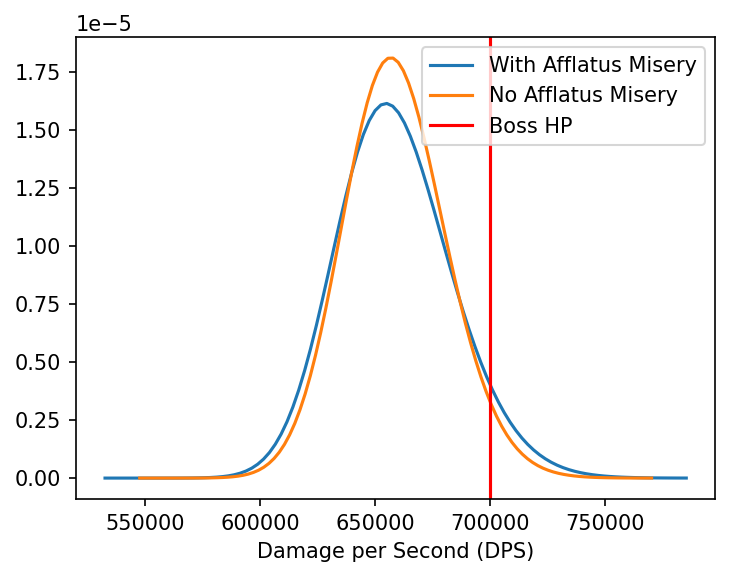

In [12]:
# Back to DPS
whm.attach_rotation(reference_rotation, t=1, convolve_all=True)

modified_rotation = reference_rotation.copy()
# Add 4 glare III casts and remove afflatus misery
modified_rotation.loc[modified_rotation['action_name'] == "Glare III", "n"] = 35
modified_rotation = modified_rotation[modified_rotation["base_action"] != "Afflatus Misery"]

mind = 3341
intelligence = 410
vit = 3280
strength = 213
dexterity = 411
determination = 1939
sks = 400
sps = 820
ten = 400
dh = 724
ch = 2346
wd = 128
delay = 3.44

whm_modified = Healer(mind, intelligence, vit, strength, dexterity, determination,
             sks, sps, ten, ch, dh, wd, delay)

whm_modified.attach_rotation(modified_rotation, t=1, convolve_all=True)

fig, ax = plt.subplots(1,1, figsize=(5.5,4), dpi=150)

whm.plot_rotation_distribution(ax=ax, label="With Afflatus Misery")
whm_modified.plot_rotation_distribution(ax=ax, label="No Afflatus Misery")
ylim = ax.get_ylim()
ax.plot([boss_hp, boss_hp], ylim, label="Boss HP", c="red")
ax.set_ylim(ylim)

ax.legend()
plt.show()


In [13]:
print(f"Original rotation, % of kills {t_ex}s or faster: {(100-get_dmg_percentile(boss_hp, whm.rotation_dps_distribution, whm.rotation_dps_support)):.1f}%")
print(f"New rotation, % of kills {t_ex}s or faster: {(100-get_dmg_percentile(boss_hp, whm_modified.rotation_dps_distribution, whm_modified.rotation_dps_support)):.1f}%")
print()
print("First three moments (total damage dealt)")
pd.DataFrame.from_dict({
    "original_rotation": [whm.rotation_mean, whm.rotation_std, whm.rotation_skewness],
    "new_rotation": [whm_modified.rotation_mean, whm_modified.rotation_std, whm_modified.rotation_skewness]
    },
    orient="index",
    columns=["mean", "standard deviation", "skewness"]
)

Original rotation, % of kills 96s or faster: 6.2%
New rotation, % of kills 96s or faster: 3.8%

First three moments (total damage dealt)


,mean,standard deviation,skewness
original_rotation,658977.4,25312.3,0.3
new_rotation,658973.2,22293.0,0.2


Both rotations deal effectively the same mean damage, but the resulting damage distributions are visibly different. The standard deviation of the rotation with Afflatus Misery is about 3000 damage (~30 DPS) higher and the skewness is ~1.7-times larger at 0.31 vs 0.19. The larger standard deviation stretches out the damage distribution, making higher-damage runs more likely. The larger positive skewness imparts a similar effect by increasing probability density at higher-damage values. Intuitively, these features of the new damage distribution makes sense. However, the magnitude that this rotational change affects the percent of kills faster than 96s is less clear by visual inspection alone. Finding the percentiles corresponding to boss HP informs us that:

* Percent of kills <= 96s for original rotation with Afflatus Misery: 6.2%
* Percent of kills <= 96s for modified rotation replacing Afflatus Misery with Glare III casts: 3.8%

Even though both rotations deal exactly the same potency, how potency is dealt and how it interacts with damage variability in the battle system reduces the chance of achieving a kill time under 96s for the new rotation by nearly half! The magnitude these rotational changes affect these percentages are likely larger compared a full party because the rotation is only 96s and the change to the rotation has a relatively large impact to the damage distribution. However, these results suggest that to accurately compare how changes to a rotation can affect kill time probability, detailed knowledge of the damage distribution may need to be known. Reporting a mean and standard deviation is likely insufficient, and even approximate methods like random sampling could require very large sample sizes to thoroughly resolve differences in tails of the distribution with statistical certainty. This is especially true when the differences between damage distributions are smaller. 

While this analysis quantitatively concludes which damage distribution will have a greater percent of kills faster than a certain time, it is unable to explain *why* the damage distributions are different. The decision space for rotations, party compositions, and job builds grows combinatorically and thoroughly enumerating this space to find the "best" damage distribution is intractable. Intuition for how changes to these aspects might affect damage distributions is essential for efficiently generating and proposing changes. Indeed, many speed kill teams have heuristics to guide these decisions - RNG Factory aims increase the effects damage variability as much as possible. For example, high potency actions increase the variance and skewness of the damage distribution, which could inform party composition. SGE offers damage variability through its high-potency Phlegma, but SCH also offers variability with Chain Stratagem by increasing the critical hit rate. Proc-based jobs with stochastic rotations are generally believed to have greater variance than jobs with deterministic rotations, e.g., DNC vs. MCH. Even "gambling" for extra DoT ticks because of forced downtime can be modeled as a stochastic rotation and accounted for in the damage distribution. A job build utilizing Skill/Spell Speed and Determination might have a higher average damage but also lower variability than a Critical Hit/Direct Hit Rate build. Encounter-specific considerations like forced downtime or expected kill times that occur near/during burst windows can lead to even further experimentation.

Guiding heuristics can help propose many "what ifs", but these choices often have competing effects that makes which option to pick unclear. These analyses can definitively conclude which changes lead to a greater increase the probability of faster kill times, but accurate models of damage distributions are required; small changes to the shape of the damage distribution can lead large differences in kill time probabilities since teams are trying sample the tail of the damage distribution. It is not unreasonable to believe that many small but judiciously selected changes to rotations, composition, and job builds could lead to kill time differences on the order of seconds. 

## Example 2: Damage distributions from a high-DPS and mid-DPS p9s kill

As a concluding example, we look at two WHM rotations actually performed in-game for p9s kills - one with [abnormally high DPS](https://www.fflogs.com/reports/NJz2cbM4mZd1hajC#fight=12&type=damage-done) and another [with more average DPS](https://www.fflogs.com/reports/tqv4JXPKQyrR9hY2#fight=7&type=damage-done). These examples illustrate what DPS distributions look like for actual rotations performed in an optimized setting and analysis is more parsing-oriented than speed kill-oriented - this only looks at a single job without any raid buffs and WHM is typically not used in a speed kill setting. The first rotation resulted in rank 50 for aDPS (equal to raw DPS for WHM). The second rotation is similar with the same party composition with a similar rotation but much lower hit-type rates, resulted in rank 1003 for aDPS.

Once again, a WHM rotation is analyzed, using a [build that is now BiS](https://etro.gg/gearset/a581634a-6def-4150-903f-2d91026471b6).

This section also illustrates the usefulness of the FFLogs API for helping create baseline rotations. Probably one of the most tedious portions for computing DPS distributions is defining a rotation that correctly assigns damage/hit-type buffs and accounts for all usages of each action. Each rotation will vary for each job/party composition along with each specific raid floor. Using routine data transformation techniques like value mapping and aggregating, an `ffxiv_stats`-compatible rotation for a job or party can readily be created by querying the FFLogs API for damage events. An example of a real, in-game WHM rotation is shown below. The party composition only has two raid buffs, but still results in a rotation with many actions - one could imagine how many action permutations exist in a full buff comp or job with more actions.

In [35]:
good_actions_df = pd.read_json("data/snoopy_good_action_df.json")
good_rotation_df = pd.read_json("data/snoopy_good_rotation_df.json")
good_rotation_df.sort_values(["base_action", "n"], ascending=[True, False])

,action_name,base_action,n,p,buffs,l_c,main_stat_add,potency,damage_type
14,Afflatus Misery,Afflatus Misery,4,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.0],1621,0,1240,direct
20,Afflatus Misery-AC_CS,Afflatus Misery,2,"[0.517667, 0.30533299999999997, 0.111333, 0.06...",[1.03],1621,0,1240,direct
24,Afflatus Misery-AC_CS_Pot,Afflatus Misery,1,"[0.517667, 0.30533299999999997, 0.111333, 0.06...",[1.03],1621,262,1240,direct
9,Assize,Assize,7,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.0],1621,0,400,direct
19,Assize-AC_CS,Assize,2,"[0.517667, 0.30533299999999997, 0.111333, 0.06...",[1.03],1621,0,400,direct
18,Assize-AC_CS_Pot,Assize,2,"[0.517667, 0.30533299999999997, 0.111333, 0.06...",[1.03],1621,262,400,direct
5,Dia,Dia,12,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.0],1621,0,65,direct
21,Dia-AC_Pot,Dia,1,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.03],1621,262,65,direct
22,Dia-Pot,Dia,1,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.0],1621,262,65,direct
0,Dia (tick),Dia (tick),116,"[0.599967, 0.22303299999999998, 0.129032999999...",[1.0],1621,0,65,magic-dot


In [36]:
# Set stats and calculate the DPS distribution
mind = 3533
intelligence = 410
vit = 3618
strength = 213
dexterity = 411
determination = 2047
sks = 400
sps = 664
ten = 400
dh = 1012
ch = 2502
wd = 132
delay = 3.44

good_whm = Healer(mind, intelligence, vit, strength, dexterity, determination,
                  sks, sps, ten, ch, dh, wd, delay)
t_good = 7*60+17-23 # Factoring out downtime is just approximate, it doesn't need to be exact.
good_whm.attach_rotation(good_rotation_df, t_good)
print(f"Rotation mean: {good_whm.rotation_mean:.1f}")
print(f"Rotation std:  {good_whm.rotation_std:.1f}")
print(f"Rotation skew: {good_whm.rotation_skewness:.2f}")

Rotation mean: 8473.4
Rotation std:  174.0
Rotation skew: 0.13


The rotation DPS distribution occurs over 6:54 and is fairly normal with a mean of 8,473 DPS, standard deviation of 174 DPS, and slight positive skewness of 0.13 - about half that of the 96s example rotation. As before, we can compute the overall DPS, along with the DPS for each ability. 

In [37]:
good_action_dps = (good_actions_df[["ability_name", "amount"]].groupby("ability_name").sum() / t_good).reset_index()
total_dps = good_action_dps['amount'].sum()
print(f"Total DPS: {total_dps:0.0f}")
good_action_dps


Total DPS: 9029


,ability_name,amount
0,Afflatus Misery,1349.1
1,Assize,576.7
2,Dia,109.1
3,Dia (tick),1185.2
4,Glare III,5801.7
5,attack,6.9


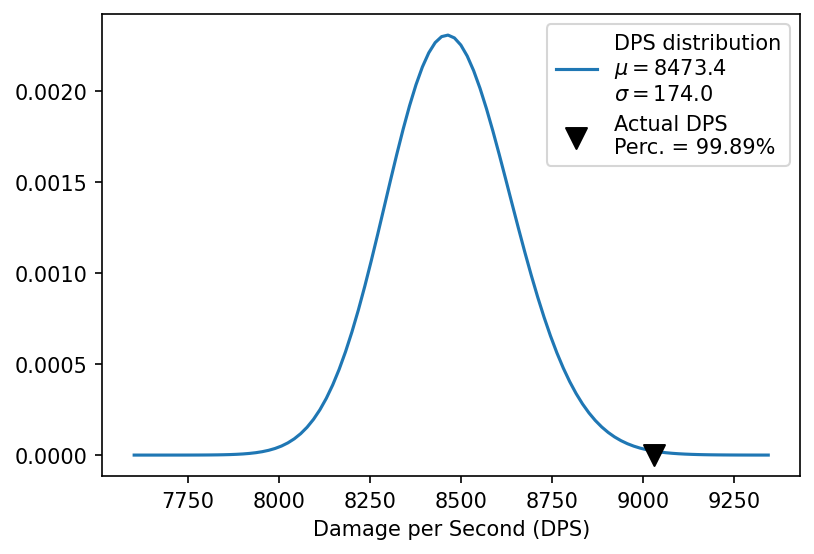

In [38]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)

label_str = f"""DPS distribution
$\mu = ${good_whm.rotation_mean:.1f} 
$\sigma = ${good_whm.rotation_std:.1f}"""

good_whm.plot_rotation_distribution(ax=ax, label=label_str)

label_str = f"""Actual DPS
Perc. = {get_dmg_percentile(total_dps, good_whm.rotation_dps_distribution, good_whm.rotation_dps_support):.2f}%"""

ax.scatter(total_dps, 0, marker='v', color='k', s=100, zorder=50, label=label_str)
ax.legend()
plt.show()

The actual DPS is deep into the tail and corresponds to the 99.89th percentile of the distribution - a 1 in 10,000 run. The run was "only" rank 50 for aDPS, likely due to very few party buffs. This run was unsurprisingly rank 2 for rDPS, which attempts to control for the contributions from buffs. Once again, the DPS distributions for each action can be plotted and the actual DPS values are overlaid. A table reporting the expected, average DPS, actual DPS dealt, and corresponding percentile in the DPS distribution is also shown.

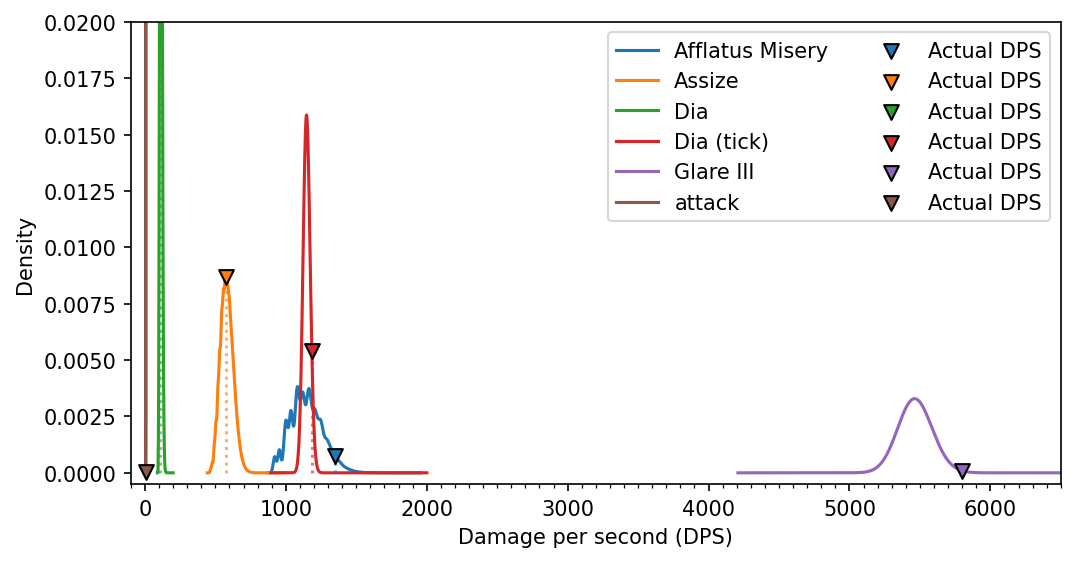

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150)
good_whm.plot_unique_action_distributions(ax=ax)


for c, x in enumerate(good_action_dps.values):
    d = good_whm.unique_actions_distribution[x[0]]
    idx = np.abs(d['support'] - x[1]).argmin()

    # Could use stem, but there's not much customization
    ax.scatter(x[1], d['dps_distribution'][idx], marker='v', label="Actual DPS", s=50, c=f'C{c}', edgecolors='k', zorder=5)
    ax.plot([x[1], x[1]], [0, d['dps_distribution'][idx]], linestyle=(0, (1, 1.5)), c=f'C{c}', zorder=4, alpha=0.6)

ax.set_ylim(-0.0005, 0.02)
ax.set_xlim(-100, 6500)
ax.set_xlabel('Damage per second (DPS)')
ax.set_ylabel('Density')
ax.xaxis.set_minor_locator(ml_100)
ax.legend(ncol=2)
plt.show()

In [40]:
good_summary = summarize_actions(good_actions_df, good_whm.unique_actions_distribution, t_good).sort_values("actual_dps_dealt", ascending=False)
good_summary

,ability_name,expected_dps,actual_dps_dealt,percentile
4,Glare III,5468.1,5801.7,99.6
0,Afflatus Misery,1148.9,1349.1,95.3
3,Dia (tick),1148.4,1185.2,92.6
1,Assize,581.8,576.7,47.5
2,Dia,114.5,109.1,26.2
5,attack,6.0,6.9,100.0


Aside from Assize and Dia (application), most actions are deep into the tails of the DPS distribution. One particularly interesting feature of the above plot is how Dia ticks and Afflatus misery have effectively identical mean DPS values. However, because Afflatus Misery is a high-potency ability with few hits, its variance is significantly larger than the low-potency Dia with many ticks. There is 163 DPS discrepancy for the two actions even though they are at similar percentiles for their respective DPS distributions. It is unsurprising to see why people engaged in parsing/speed running tend to dislike the design approach of a few high potency actions. This is also likely why SE has turned many of these high-potency actions into guaranteed critical/direct hits.

### Mid-DPS kill

This is a kill with the same group with a similar kill time, but with more average DPS because of a "bad" hit-type sample. Much of the initial analysis is the same, so most discussion will be brief. Additionally, results from the high-DPS run will also be plotted against as comparison to illustrate the magnitude differences in hit-types can have on total DPS. Adhering to proper technical terminology usage, quantities from the high-DPS run shall be prefixed with "good" (good rotation, good DPS distribution, etc) and quantities from mid-DPS run shall be prefixed with "mid".

In [41]:
mid_actions_df = pd.read_json("data/snoopy_mid_action_df.json")
mid_rotation_df = pd.read_json("data/snoopy_mid_rotation_df.json")

In [42]:
# Set stats and calculate the DPS distribution
mind = 3533
intelligence = 410
vit = 3618
strength = 213
dexterity = 411
determination = 2047
sks = 400
sps = 664
ten = 400
dh = 1012
ch = 2502
wd = 132
delay = 3.44

mid_whm = Healer(mind, intelligence, vit, strength, dexterity, determination,
                 sks, sps, ten, ch, dh, wd, delay)
t_mid = 7*60+11-23
mid_whm.attach_rotation(mid_rotation_df, t_mid)
print(f"Rotation mean: {mid_whm.rotation_mean:.1f}")
print(f"Rotation std:  {mid_whm.rotation_std:.1f}")
print(f"Rotation skew: {mid_whm.rotation_skewness:.2f}")


Rotation mean: 8351.2
Rotation std:  174.7
Rotation skew: 0.13


In [43]:
mid_action_dps = (mid_actions_df[["ability_name", "amount"]].groupby("ability_name").sum() / t_mid).reset_index()
total_mid_dps = mid_action_dps['amount'].sum()

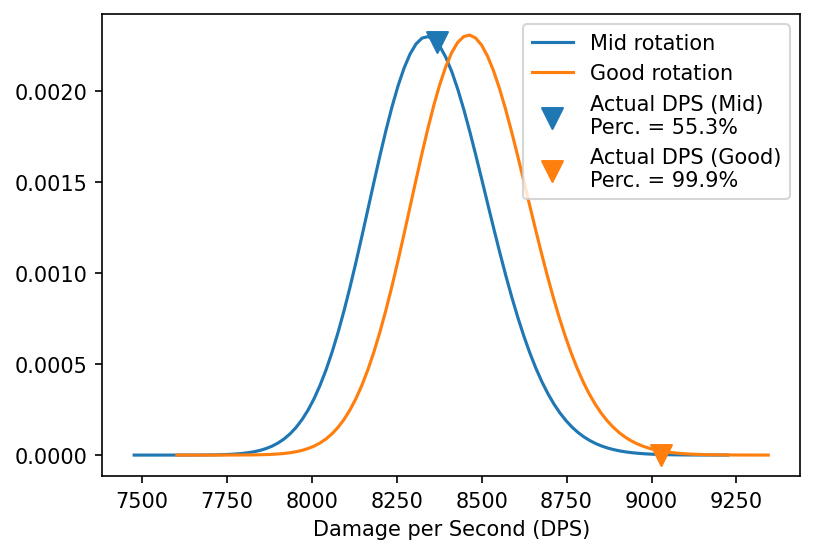

In [44]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
label_str = f"""DPS distribution
$\mu = ${mid_whm.rotation_mean:.1f} 
$\sigma = ${mid_whm.rotation_std:.1f}"""

mid_whm.plot_rotation_distribution(ax=ax, label="Mid rotation")
good_whm.plot_rotation_distribution(ax=ax, label='Good rotation')

label_str=f"""Actual DPS (Mid)
Perc. = {get_dmg_percentile(total_mid_dps, mid_whm.rotation_dps_distribution, mid_whm.rotation_dps_support):.1f}%"""
ax.scatter(total_mid_dps, 0.00227, marker='v', color='C0', s=100, zorder=50, label=label_str)

label_str=f"""Actual DPS (Good)
Perc. = {get_dmg_percentile(total_dps, good_whm.rotation_dps_distribution, good_whm.rotation_dps_support):.1f}%"""
ax.scatter(total_dps, 0, marker='v', color='C1', s=100, zorder=50, label=label_str)

ax.legend()
plt.show()

The DPS distributions and actual DPSs dealt are plotted above. One immediately noticeable difference is the mid rotation has a mean DPS about 120 DPS lower than the good rotation. A large contribution to this difference is the mid rotation had 2 Glare III casts missed. One was an interrupted cast and one did not register since the boss had just died. Each glare is worth about 40 DPS, for a total of 80 DPS - about how much the two DPS distributions are offset by.

The mid run is quite average and lies at the 55th percentile of the DPS distribution, and 660 DPS lower than the good run (and likely ca. 540 - 560 DPS lower with no dropped Glare III casts). These results also illustrate the importance of having a refined rotation. Even with some rotational mistakes like missing casts and average hit-type RNG, this refined rotation and kill time yielded rank 1003 (aDPS) and rank 300 (rDPS). Although this run sampled a medium percentile value, the rDPS is in the 98th percentile for all runs on FFLogs. The discrepancy is likely because most of the player base execute rotations which sample lower-damage rDPS distributions. These rotations could lead to lower damage rDPS distributions for many reasons: dropping casts, overhealing/relying on GCD healing, bad healer synergy (chadding), non-BiS gear, having to (hard) raise, or differences in kill times (which can significantly influence aDPS for most jobs/rDPS for jobs with raid buffs and is often a key difference between speed kills and parsing).

Lastly, we look at the DPS distributions for each ability along with the actual DPS each ability dealt, noted by circles. For comparison, the DPS dealt by Glare III from the good run is also shown as a triangle.

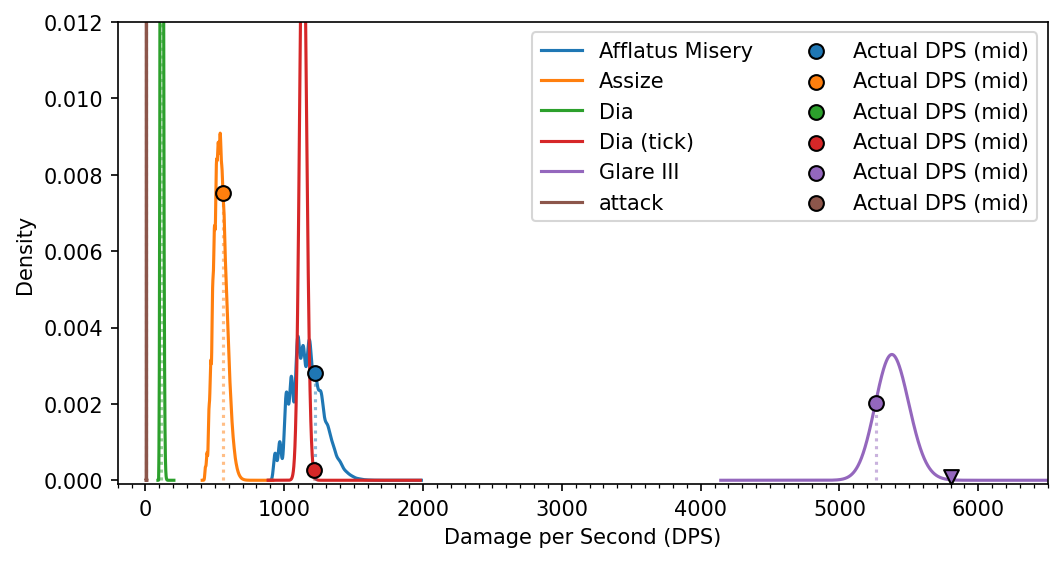

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150)
mid_whm.plot_unique_action_distributions(ax=ax)

for c, x in enumerate(mid_action_dps.values):
    d = mid_whm.unique_actions_distribution[x[0]]
    idx = np.abs(d['support'] - x[1]).argmin()

    # Could use stem, but there's not much customization
    ax.scatter(x[1], d['dps_distribution'][idx], marker='o', label="Actual DPS (mid)", s=50, c=f'C{c}', edgecolors='k', zorder=5)
    ax.plot([x[1], x[1]], [0, d['dps_distribution'][idx]], linestyle=(0, (1, 1.5)), c=f'C{c}', zorder=4, alpha=0.5)

# Showing where Glare III from the good run is
x = good_action_dps[good_action_dps['ability_name'] == "Glare III"]['amount'].values[0]
d = good_whm.unique_actions_distribution['Glare III']
idx = np.abs(d['support'] - x).argmin()
ax.scatter(x, d['dps_distribution'][idx], marker='v', s=50, c='C4', edgecolors='k', zorder=5)
ax.plot([x, x], [0, d['dps_distribution'][idx]], linestyle=(0, (1, 1.5)), c='C4', zorder=4)

ax.set_ylim([-1e-4, 0.012])
ax.set_xlim(-200, 6500)
ax.legend(ncol=2)
ax.set_xlabel('Damage per Second (DPS)')
ax.set_ylabel('Density')
ax.xaxis.set_minor_locator(ml_100)
plt.show()

Aside from Glare III, most actions are actually average or slightly above average. Glare III is quite below the average at the 15.6th percentile, which unfortunately lowers DPS by the greatest extent. A similar comparison is made in the table below, which reports the expected DPS for the mid run, the actual DPS and corresponding percentile for the mid run, and the actual DPS and corresponding percentile for the good run. The DPS for Glare III is 550 DPS lower compared to the good run, which accounts for most of the DPS difference for the entire rotation. The remainder for most of the damage difference is from Afflatus Misery. 

In [47]:
mid_summary = summarize_actions(mid_actions_df, mid_whm.unique_actions_distribution, t_mid).sort_values("actual_dps_dealt", ascending=False)
mid_summary.merge(good_summary[['ability_name', 'actual_dps_dealt', 'percentile']], on='ability_name', suffixes=('_mid_run', '_good_run'))

,ability_name,expected_dps,actual_dps_dealt_mid_run,percentile_mid_run,actual_dps_dealt_good_run,percentile_good_run
0,Glare III,5382.9,5259.8,15.6,5801.7,99.6
1,Afflatus Misery,1165.3,1222.6,70.3,1349.1,95.3
2,Dia (tick),1136.6,1210.9,99.8,1185.2,92.6
3,Assize,539.1,558.3,68.2,576.7,47.5
4,Dia,118.0,109.6,15.5,109.1,26.2
5,attack,7.0,6.9,80.5,6.9,100.0


## Conclusion

This work demonstrates how different rotations leads to different damage distributions, and how executing the rotation each time in an encounter can be thought of as sampling the damage distribution. Applications of this analysis for estimating the likelihood of kill times and other applications in a speed kill environment are discussed. Finally, an example of how damage and rotational variability affect damage dealt for a rotation performed in-game on an encounter was shown.

This work also shows the capabilities of the `ffxiv_stats` module, with regards to ease of calculating damage distributions from a rotation and job build. In addition, one of the largest and most tedious challenges is creating realistic rotations that properly account for all present buffs in an 8-person party. It was shown how the FFLogs API can be used to alleviate many of those challenges for creating a baseline rotation. While strengths of the `ffxiv_stats` module were shown, there are some current limitations including:

* Damage calculations from potency:
    * Only calculations for healers are properly supported. The framework for other jobs is there, but they have not been tested.
    * Damage calculations can only be performed for jobs at level 90.
    * Calculating the damage buff for hit type buffs acting upon guaranteed critical/direct hits.
    * Calculating damage from pets.

* Damage variability calculations:
    * Built-in support for stochastic rotations. Examples of how these damage distributions can be calculated exist, but they are not integrated with the `Rotation` class.
    * The theory for modeling all forms of stochastic rotations, like Pitch Perfect or accumulating the maximum number of Army's Paeon stacks, still needs to be developed.

Feel free to DM me (@cherryjesus) if you are interested in implementing this module for a project, or help contribute [to the repo](https://github.com/ffxiv-acerola/ffxiv_stats).

## Acknowledgements

Many thanks to:

* @joncho and @nemekh for discussions helping improve previous papers on damage variability.
* @fryteavarice comparing and validating damage distribution calculations using different methods.
* @acedia for discussions to help frame how damage variability has been, and could be used in speed kills.

## Appendix

Contains API calls and the KS test between the theoretical DPS distribution and in-game samples.

These are just here for reference, they're not really meant to be called since data is stored in `data` and the `rla` module requires an API token for FFLogs to be configured.

In [2]:
# Numpy arrays cannot be serialized to json, run this before any API calls
class NDArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

### Striking dummy test rotation logs

In [ ]:
# Log with fights is https://www.fflogs.com/reports/d2KkqT6Pg17BbLCv

fight_code = 'd2KkqT6Pg17BbLCv'
fight_id = 51 # good run
fight_id = 45 # bad run

job = 'WhiteMage'

start_time = 0
end_time = int(time.time())

medication_amt = 262
dh = 724
ch = 2346

reference_rotation = pd.read_json('data/whm_reference_rotation.json')

In [ ]:
fight_range = range(1, 55)
all_rotations = {}
all_actions = {}
len_check = 106 # API call must have this many records

# Loop through rotation samples, only keep rotations which match the reference rotation
for fight_id in fight_range:
    if fight_id % 5 == 0:
        print(f"Fight {fight_id}")
    actions = get_pull_dps_actions_from_fflogs(fight_code, fight_id, job, start_time, end_time)
    # Check number of records from api is correct
    if len(actions) == len_check:
        actions_df = create_action_df(actions, ch, dh, medication_amt)
        rotation_df = create_rotation_df(actions_df)

        # Check number of action usages are all equal
        if (reference_rotation['n'] == rotation_df['n']).all():
            all_actions[fight_id] = actions_df.to_dict()
            all_rotations[fight_id] = rotation_df.to_dict()

In [ ]:
# Save to disc as json
with open("data/all_action_dfs.json", "w") as f: 
    json.dump(all_actions, f, cls=NDArrayEncoder)

with open("data/all_rotation_dfs.json", "w") as f: 
    json.dump(all_rotations, f, cls=NDArrayEncoder)

### KS test between in-game samples and predicted damage distribution

The [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) tests if a set of samples is drawn from a particular distribution. In this case our samples are the logs on a striking dummy and the distribution is the DPS distribution from `ffxiv_stats`. The p-value not small enough to reject the null hypothesis, suggesting these samples are drawn from the DPS distribution. There are only 49 samples, so there likely isn't enough power to discern small differences between slightly different DPS distributions, though. More samples weren't obtained largely because each sample takes about 2 minutes to obtain. 

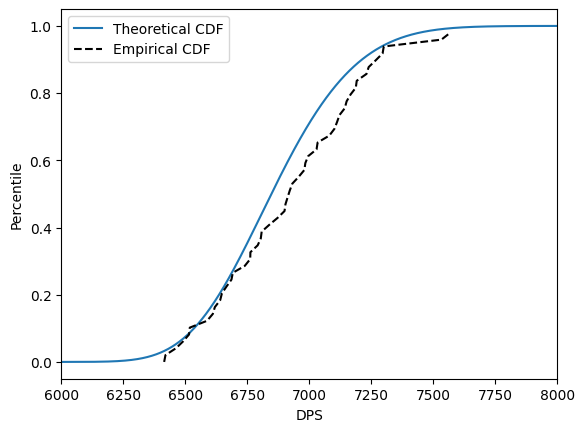

KstestResult(statistic=0.12877713361472404, pvalue=0.3597739677862456, statistic_location=6900.145833333333, statistic_sign=-1)

In [51]:
from scipy import stats

###############
### Samples ###
###############

# Load in all actions for each sample (pull) as nested dictionaries
# See the appendix for how the API calls are performed
with open('data/all_action_dfs.json') as json_data:
    all_actions = json.load(json_data)

# Total dmg dealt is just sum of "amount" field when converted to a dataframe
samples_total_dmg = []
for (k, v) in all_actions.items():
    samples_total_dmg.append(pd.DataFrame(v)['amount'].sum())

# Convert to array and also compute DPS
samples_total_dmg = np.array(samples_total_dmg)
samples_dps = samples_total_dmg / t_ex

##############
## True CDF ##
##############

reference_rotation = pd.read_json('data/whm_reference_rotation.json')
t_ex = 96

mind = 3341
intelligence = 410
vit = 3280
strength = 213
dexterity = 411
determination = 1939
sks = 400
sps = 820
ten = 400
dh = 724
ch = 2346
wd = 128
delay = 3.44

# Job object to convert potencies to damage dealt
whm = Healer(mind, intelligence, vit, strength, dexterity, determination,
             sks, sps, ten, ch, dh, wd, delay)
whm.attach_rotation(reference_rotation, t_ex, convolve_all=True)

def damage_cdf(dps):
    dx = whm.rotation_dps_support[1] - whm.rotation_dps_support[0]
    F = np.cumsum(whm.rotation_dps_distribution) * dx
    # Same as the percentile function,
    # but getting cute with broadcasting lets us pass in a numpy array of samples
    return F[(np.abs(whm.rotation_dps_support - dps[:, np.newaxis])).argmin(axis=1)]

#############
## KS Test ##
#############

# Plot empirical and theoretical CDFs
plt.plot(whm.rotation_dps_support, damage_cdf(whm.rotation_dps_support), label='Theoretical CDF')
plt.plot(np.sort(samples_dps), np.linspace(0, 1, len(samples_dps), endpoint=False), '--', label='Empirical CDF', c='k')
plt.xlim(6000, 8000)
plt.legend()
plt.xlabel("DPS")
plt.ylabel("Percentile")
plt.show()

# Actual test
stats.kstest(samples_dps, lambda x: damage_cdf(x))

### Good WHM run

In [6]:
fight_code = "tLZAywmgjfTYDRFz"
fight_id = 11
job = 'WhiteMage'

start_time = 0
end_time = int(time.time())

medication_amt = 262
dh = 1012
ch = 2502

In [7]:
actions = get_pull_dps_actions_from_fflogs(fight_code, fight_id, job, start_time, end_time)
good_actions_df = create_action_df(actions, ch, dh, medication_amt=medication_amt)
good_rotation_df = create_rotation_df(good_actions_df)
good_actions_df.to_json("data/snoopy_good_action_df.json")
good_rotation_df.to_json("data/snoopy_good_rotation_df.json")

### Meh WHM run

In [106]:
fight_code = "tLZAywmgjfTYDRFz"
fight_id = 6
job = 'WhiteMage'

start_time = 0
end_time = int(time.time())

medication_amt = 262
dh = 1012
ch = 2502

In [119]:
actions = get_pull_dps_actions_from_fflogs(fight_code, fight_id, job, start_time, end_time)
# The final Glare cast happened after the boss died but is still included
# Can probably check when the boss dies and ignore everything past that later,
# but indexing out the final cast right now glare is easy
mid_actions_df = create_action_df(actions, ch, dh, medication_amt=medication_amt).iloc[:-1]
mid_rotation_df = create_rotation_df(mid_actions_df)

mid_actions_df.to_json("data/snoopy_mid_action_df.json")
mid_rotation_df.to_json("data/snoopy_mid_rotation_df.json")